# Task 8 - Issues

#### Extract Senatorial Candidates stands on issues using LDA Mallet


In [51]:
## Install Packages

In [1]:
#install packages
!pip install pyldavis

!pip install streamlit
!pip install -U pandas-profiling

In [2]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

# import pickle
import pickle

# import wordcloud
from wordcloud import WordCloud

# import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# import corpus 
from nltk import corpus 
import nltk.corpus as Corpus
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def read_file(path):
  df = pd.read_csv(path)
  df = df[~df.lemma_text_flatten.isna()]
  df = df.drop('lemma_text', axis=1)
  df['lemma_text'] = df.lemma_text_flatten.apply(lambda x: [text for text in str(x).split()])
  return df

In [5]:
text_path = '/content/drive/MyDrive/Omdena_Philippines_Politician_Data_data_processed_translated/data_processed_translated.csv'
df = read_file(text_path)
df.head(2)

,date_posted,title,content,candidate,page_url,source,language,text_translated,text_clean,lemma_text_flatten,lemma_text
0,11/22/2021,,"KA LEODY: AYUNGIN SHOAL ATTACK, RESULT OF DUTE...",Leody de Guzman,,Facebook Post,en,"KA LEODY: AYUNGIN SHOAL ATTACK, RESULT OF DUTE...","KA LEODY: AYUNGIN SHOAL ATTACK, RESULT OF DUTE...",leody shoal attack result duterte presence can...,"[leody, shoal, attack, result, duterte, presen..."
1,11/05/2021,,"Paglikha ng DHSUD ng anti-corruption panel, pi...",Greco Belgica,,Facebook Post,en,"Paglikha ng DHSUD ng anti-corruption panel, pi...","Paglikha ng DHSUD ng anti-corruption panel, pi...",paglikha dhsud anticorruption panel pinuri gre...,"[paglikha, dhsud, anticorruption, panel, pinur..."


#Get the Senatorial candidates data`

In [6]:
Senatorial_Candidates = ['Neri Colmenares', 'Dick Gordon']

In [7]:
def get_candidate_data(Senatorial_Candidates_list, df=df):
  df_list = {}
  for candidate in Senatorial_Candidates_list:
    candidate_df = df[df.candidate == candidate]
    candidate_df = candidate_df.reset_index(drop=True)
    df_list[candidate] = candidate_df
  return df_list

In [8]:
candidate_data = get_candidate_data(Senatorial_Candidates)

colmenares_df = candidate_data['Neri Colmenares']
gordon_df = candidate_data['Dick Gordon']

## Build LDA Mallet Model

In [60]:
### Bigrams and Trigrams

In [9]:
def create_bigrams(texts):
  # Build the bigram model
  bigram = models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.

  # Faster way to get a sentence clubbed as a bigram
  bigram_model = models.phrases.Phraser(bigram)

  return [bigram_model[doc] for doc in texts]

In [10]:
def create_trigrams(texts):
  # Build the trigram models
  trigram = models.Phrases(texts, threshold=100)  

  trigram_model = models.phrases.Phraser(trigram)

  return [trigram_model[doc] for doc in texts]
  

In [11]:
def processed_trigram(text):
  bigram_texts = create_bigrams(text)
  trigram_texts = create_trigrams(bigram_texts)

  return trigram_texts

In [12]:
colmenares_texts = processed_trigram(list(colmenares_df['lemma_text']))
gordon_texts = processed_trigram(list(gordon_df['lemma_text']))

### Gensim Dictionary and Corpus

In [13]:
def create_dict_corpus(texts):
  dictionary = corpora.Dictionary(texts)
  dictionary.filter_extremes(no_below=5, no_above=0.5)
  corpus = [dictionary.doc2bow(text) for text in texts]
  return dictionary, corpus
  

In [14]:
colmenares_dict, colmenares_corpus = create_dict_corpus(colmenares_texts)
gordon_dict, gordon_corpus = create_dict_corpus(gordon_texts)

In [15]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [ ]:
def download_mallet():
  !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
  !unzip mallet-2.0.8.zip
download_mallet()

In [17]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [18]:
def build_lda_mallet_model(corpus, id2word, num_topics, alpha, iterations, mallet_path=mallet_path):
  model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, alpha=alpha, iterations=iterations)
  return model

In [19]:
def save_model(model, model_name):
  pickle.dump(model, open(f"/content/drive/MyDrive/Omdena Philippines Politician Models Pkl/{model_name}.pkl", "wb"))

In [20]:
def load_model(model_name):
  model = pickle.load(open(f"/content/drive/MyDrive/Omdena Philippines Politician Models Pkl/{model_name}.pkl", "rb"))
  return model

In [21]:
def compute_coherence_scores(corpus, dictionary, texts, num_topics, alpha, iterations, mallet_path=mallet_path):
  model_list = []
  coherence_scores = []
  model = models.wrappers.LdaMallet(mallet_path=mallet_path, 
                                    corpus=corpus, 
                                    num_topics=num_topics,
                                    id2word=dictionary,
                                    alpha= alpha, 
                                    iterations=iterations)

  coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
  
  return coherence_model.get_coherence()

In [22]:
def tune_model(corpus, dictionary, texts):

  # Num of Topics
  num_topics = range(3, 11)

  # Alpha Values
  alpha_vals = list(np.arange(0.1, 1, 0.3))

  # Num of Iterations
  num_iterations = range(150, 400, 50)

  # Topic Threshold
  # topic_threshold_vals = list(np.arange(0.1, 1, 0.2))

  model_results = {
      'num_topics':[],
      'alpha': [],
      'iterations': [],
      # 'topic_threshold': [],
      'coherence_score': []
  }

  for num_topic in num_topics:
    for alpha_val in alpha_vals:
      for iteration in num_iterations:
        # for topic_threshold_val in topic_threshold_vals:
        coherence_score = compute_coherence_scores(corpus, 
                                                    dictionary, 
                                                    texts, 
                                                    num_topic, 
                                                    alpha_val, 
                                                    iteration) # , topic_threshold_val
        
        model_results['num_topics'].append(num_topic)
        model_results['alpha'].append(alpha_val)
        model_results['iterations'].append(iteration)
        #model_results['topic_threshold'].append(topic_threshold_val)
        model_results['coherence_score'].append(coherence_score)
  
  return pd.DataFrame(model_results)

In [23]:
colmenares_tuned_df = tune_model(colmenares_corpus, colmenares_dict, colmenares_texts)

Streaming output truncated to the last 5000 lines.
1	0.01429	inquirerdotnet abscbnnews gmanews house solon aquino lawmaker group probe news case dap budget pnoy sharethis rapplerdotcom justice casio bill inquirer 
2	0.01429	people colmenares country worker tnx time president candidate law government china day muna today support election lawyer akosilolanidora farmer duterte 
3	0.01429	house gmanews inquirerdotnet abscbnnews power solon news hike bill lawmaker probe rate sharethis law meralco budget philippine philstarnews muna deal 
4	0.01429	hike inquirerdotnet abscbnnews power pension rate gmanews bill price meralco solon house increase ss law tnx tax electricity sharethis fund 
5	0.01429	inquirerdotnet solon abscbnnews house gmanews news lawmaker muna probe law bill bloc gma_online zarate aquino palace power hike addthis price 
6	0.01429	people pension ss law inquirerdotnet congress hike bill time philippine government abscbnnews hope day tnx news pres senate year president 

<50> L

In [24]:
colmenares_tuned_df.head()

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.404057
1,3,0.1,200,0.319223
2,3,0.1,250,0.320086
3,3,0.1,300,0.322321
4,3,0.1,350,0.344826


In [25]:
def plot_num_topics(df):
  plt.figure(figsize=(8, 5))
  sns.lineplot(data=df, x='num_topics', y='coherence_score')

In [26]:
colmenares_best_model = build_lda_mallet_model(colmenares_corpus, colmenares_dict, 3, 0.1, 150)

Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 194
total tokens: 37191
<10> LL/token: -7.35103
<20> LL/token: -7.2848
<30> LL/token: -7.22952
<40> LL/token: -7.18798

0	0.03333	abscbnnews inquirerdotnet house gmanews solon news bill lawmaker probe muna law sharethis power bloc hike court budget colmenares fund group 
1	0.03333	inquirerdotnet abscbnnews gmanews solon power house hike rate probe group lawmaker muna news bill meralco law people budget colmenares china 
2	0.03333	inquirerdotnet people law pension tnx hike price day government ss bill time solon news year muna morning gmanews lawmaker colmenares 

<50> LL/token: -7.15257
<60> LL/token: -7.12795
<70> LL/token: -7.09229
<80> LL/token: -7.07559
<90> LL/token: -7.06202

0	0.03333	inquirerdotnet abscbnnews gmanews house news solon lawmaker bill probe law sharethis bloc muna gma_online aquino group case court addthis duterte 
1	0.03333	inquirerdotnet abscbnnews power solon gmanews hike rate house lawma

In [27]:
colmenares_tuned_df[colmenares_tuned_df.num_topics ==3].sort_values(by='coherence_score', ascending=False).head()

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.404057
12,3,0.7,250,0.401744
14,3,0.7,350,0.384683
9,3,0.4,350,0.380415
11,3,0.7,200,0.366441


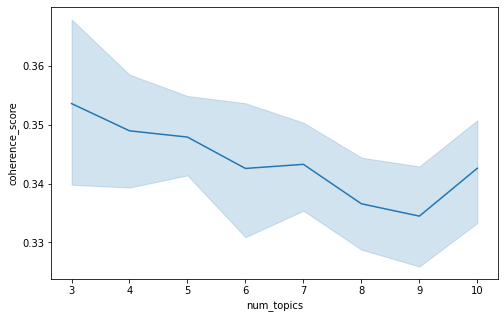

In [28]:
plot_num_topics(colmenares_tuned_df)

In [29]:
save_model(colmenares_best_model, 'colmenares_tuned_model')

In [30]:
gordon_tuned_df = tune_model(gordon_corpus, gordon_dict, gordon_texts)

Streaming output truncated to the last 5000 lines.
1	0.01429	country philippine people gordon filipino government family senator_richard time year development world today job work opportunity investment leader life nation 
2	0.01429	cross philippine prc country gordon covid philredcross people health chairman_ceo day test time area hospital senator_richard center world disease blood 
3	0.01429	law gordon people act country bill government time senator_richard chairman year system justice senate day president committee police measure case 
4	0.01429	government people investigation gordon drug country senate senator_richard official law hearing budget department case agency billion report president committee order 
5	0.01429	people cross philredcross volunteer family country philippine day today life time disaster admin staff prc filipino hero year operation gordon 
6	0.01429	team philredcross patient prc city chapter volunteer family cross hospital center ambulance assistance year aid s

In [31]:
gordon_tuned_df.head()

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.654729
1,3,0.1,200,0.684552
2,3,0.1,250,0.659797
3,3,0.1,300,0.656458
4,3,0.1,350,0.632114


In [32]:
gordon_best_model = build_lda_mallet_model(gordon_corpus, gordon_dict, 3, 0.1, 150)

Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 226
total tokens: 81848
<10> LL/token: -7.89848
<20> LL/token: -7.63767
<30> LL/token: -7.52753
<40> LL/token: -7.47571

0	0.03333	people cross country philippine government philredcross investigation gordon health time covid day volunteer department official president city money area million 
1	0.03333	gordon country people senator_richard law government time year philippine act bill senate chairman system senator filipino day case family president 
2	0.03333	philredcross prc cross team volunteer chapter family city area patient ambulance staff philippine hospital fire operation assistance center individual today 

<50> LL/token: -7.43741
<60> LL/token: -7.42402
<70> LL/token: -7.40612
<80> LL/token: -7.39564
<90> LL/token: -7.38848

0	0.03333	people cross country philippine gordon government covid health philredcross department time investigation test day senator_richard prc official million chairman_ceo case 

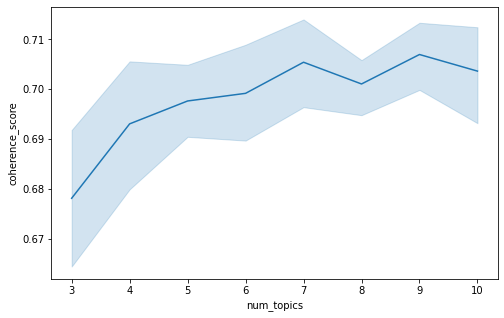

In [33]:
plot_num_topics(gordon_tuned_df)

In [34]:
save_model(gordon_best_model, 'gordon_tuned_model')

In [38]:
candidate_models = []
Senators_names = ['colmenares_tuned_model', 'gordon_tuned_model']

for candidate_name in Senators_names:
  candidate_model = load_model(candidate_name)
  candidate_models.append(candidate_model)
candidate_models

## Topic Understanding

### Find topic in each document

In [41]:
def display_topics(model):
  topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=20)] for n in range(0, model.num_topics)]
  
  # set column width
  pd.set_option('display.max_colwidth', -1)
  topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Words per Topic'], index=['Topic_'+str(t) for t in range(1, model.num_topics+1)] )
  return topics_df

In [43]:
colmenares_best_model = load_model('colmenares_tuned_model')


In [44]:
colmenares_df_topic = display_topics(colmenares_best_model)
gordon_df_topic = display_topics(gordon_best_model)

In [45]:
def display_wordcloud(df_topic, rows, cols, fig_size):

  # initiate wordcloud object
  wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

  # set the figure size
  plt.rcParams['figure.figsize'] = fig_size

  # Create subplots for each topic
  for i in range(df_topic.shape[0]):

      wc.generate(text=df_topic["Words per Topic"][i])
      
      plt.subplot(rows, cols, i+1)
      plt.imshow(wc, interpolation="bilinear")
      plt.axis("off")
      plt.title(df_topic.index[i])

  plt.show()

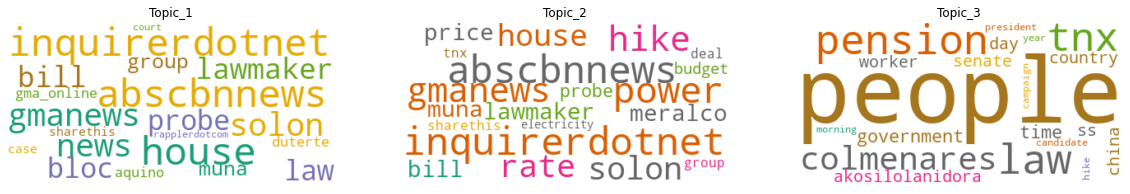

In [46]:
display_wordcloud(colmenares_df_topic, 1, 3, [20,5])

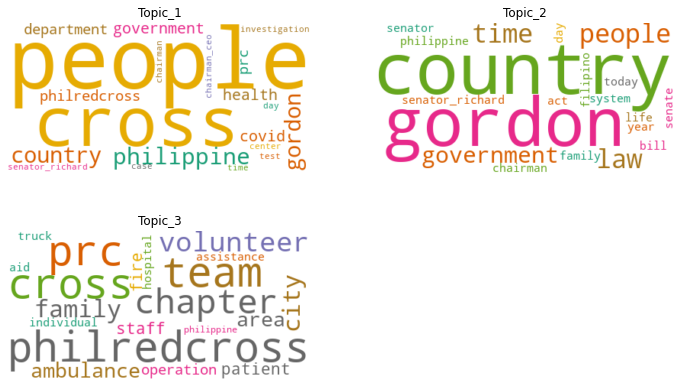

In [47]:
display_wordcloud(gordon_df_topic, 2, 2, [12,7])

### Find Dominant Topic For Each Doc

In [48]:
def create_df_dominant_topic(model, corpus, df_topic, candidate_df):
  vector = model[corpus]
  corpus_topics = [sorted(topic, key=lambda record: -record[1])[0] for topic in vector]

  # create a dataframe
  corpus_topic_df = pd.DataFrame()

  corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
  corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
  corpus_topic_df['Keywords'] = [df_topic.iloc[t[0]]['Words per Topic'] for t in corpus_topics]
  corpus_topic_df['content'] = candidate_df['lemma_text']

  return corpus_topic_df

In [60]:
colmenares_dominant_topic = create_df_dominant_topic(colmenares_best_model, colmenares_corpus, colmenares_df_topic, colmenares_df)
colmenares_dominant_topic.head(15)

,Dominant Topic,Contribution %,Keywords,content
0,3,99.06,"people, pension, law, tnx, colmenares, government, time, country, china, ss, day, worker, senate, akosilolanidora, president, year, morning, candidate, hike, campaign","[interest, lawyer, legislator, teacher, advocate, colmenares, senado]"
1,3,99.45,"people, pension, law, tnx, colmenares, government, time, country, china, ss, day, worker, senate, akosilolanidora, president, year, morning, candidate, hike, campaign","[threat, marcosduterte, tandem, one, halloween, bayan, muna, chairperson, colmenares, agrees, candidate, bongbong, year, election, would, alliance, family, two]"
2,3,97.81,"people, pension, law, tnx, colmenares, government, time, country, china, ss, day, worker, senate, akosilolanidora, president, year, morning, candidate, hike, campaign","[noninclusion, slate, neri, colmenares, leni, robredos, decision, statement]"
3,3,98.91,"people, pension, law, tnx, colmenares, government, time, country, china, ss, day, worker, senate, akosilolanidora, president, year, morning, candidate, hike, campaign","[join, movement, climate, justice, fight, world]"
4,3,99.53,"people, pension, law, tnx, colmenares, government, time, country, china, ss, day, worker, senate, akosilolanidora, president, year, morning, candidate, hike, campaign","[part, launch, campaign, labor, group, press, conference, today, agenda, announce, list, prolabor, candidate, leader, matula, elmer, bong, colmenares]"
5,3,96.04,"people, pension, law, tnx, colmenares, government, time, country, china, ss, day, worker, senate, akosilolanidora, president, year, morning, candidate, hike, campaign","[sec, bello, worker, bayan, muna, chairman, understand, iatf, resolution, employee, restaurant, basis, wage]"
6,3,98.40,"people, pension, law, tnx, colmenares, government, time, country, china, ss, day, worker, senate, akosilolanidora, president, year, morning, candidate, hike, campaign","[labor, unity, leader, union, federation, today, city, sport, club, agenda, press, conference, list, prolabor, candidate]"
7,1,96.83,"inquirerdotnet, abscbnnews, house, gmanews, news, solon, lawmaker, bill, probe, law, bloc, group, muna, gma_online, aquino, duterte, sharethis, case, rapplerdotcom, court","[remark, coc, comelec]"
8,3,99.45,"people, pension, law, tnx, colmenares, government, time, country, china, ss, day, worker, senate, akosilolanidora, president, year, morning, candidate, hike, campaign","[statement, labor, vote, colmenares, elmer, bong, join, unionist, leader, vice, president, position, government]"
9,3,95.78,"people, pension, law, tnx, colmenares, government, time, country, china, ss, day, worker, senate, akosilolanidora, president, year, morning, candidate, hike, campaign","[five, solution, government, oil, price, chairman, experience, another, hike, week, good, president, dutertes, hand]"


In [59]:
gordon_dominant_topic = create_df_dominant_topic(gordon_best_model, gordon_corpus, gordon_df_topic, gordon_df)
gordon_dominant_topic.head(15)

,Dominant Topic,Contribution %,Keywords,content
0,3,87.91,"philredcross, team, prc, cross, chapter, volunteer, family, city, ambulance, area, patient, fire, staff, operation, assistance, hospital, truck, individual, aid, philippine","[november, family, flood, davao, city, del, sur, philippine, cross, deploy, water, rescue, equipment, rubber, boat, life, vest, among, others, resident, near, bank]"
1,1,98.64,"people, cross, philippine, country, gordon, government, health, covid, philredcross, prc, department, senator_richard, day, time, test, investigation, chairman, center, chairman_ceo, case","[tingnan, ilang, personalidad, sangkot, gobyerno, irerekomendang, makasuhan, base, report, senate, ribbon, committee, scandal, probe, servicedepartment, budget, management, psdbm]"
2,2,97.09,"country, gordon, people, law, time, government, senator_richard, year, philippine, bill, act, senate, family, filipino, chairman, day, life, senator, system, today","[get, woman, charm, one, across, amazes, every, time, family, friend, companion, stranger, memory]"
3,2,99.06,"country, gordon, people, law, time, government, senator_richard, year, philippine, bill, act, senate, family, filipino, chairman, day, life, senator, system, today","[club, lubang, community, service, webinar, project, topic, change, livesevery, matter]"
4,1,88.28,"people, cross, philippine, country, gordon, government, health, covid, philredcross, prc, department, senator_richard, day, time, test, investigation, chairman, center, chairman_ceo, case","[pulitzer, manny, mogato, face, shield, place, corruption, government, contract, corporation, text]"
5,1,99.18,"people, cross, philippine, country, gordon, government, health, covid, philredcross, prc, department, senator_richard, day, time, test, investigation, chairman, center, chairman_ceo, case","[senator, dick, gordon, tiktok, account, content, watch, video]"
6,1,99.27,"people, cross, philippine, country, gordon, government, health, covid, philredcross, prc, department, senator_richard, day, time, test, investigation, chairman, center, chairman_ceo, case","[procurement, servicedepartment, budget, management, lloyd, christoper, lao, contempt, today, multibillion, contract, corporation]"
7,1,45.27,"people, cross, philippine, country, gordon, government, health, covid, philredcross, prc, department, senator_richard, day, time, test, investigation, chairman, center, chairman_ceo, case","[congratulate, vienne, ducusin, pinlac, licensure, examination, one, philippine, cross, volunteer, doctor, facility, ateneo, manila, university, man]"
8,1,99.34,"people, cross, philippine, country, gordon, government, health, covid, philredcross, prc, department, senator_richard, day, time, test, investigation, chairman, center, chairman_ceo, case","[highlight, yesterday, multibillion, contract, government, supplier, corporation, purchase, covid, supply, equipment]"
9,1,73.07,"people, cross, philippine, country, gordon, government, health, covid, philredcross, prc, department, senator_richard, day, time, test, investigation, chairman, center, chairman_ceo, case","[ojo, night, november, sen, dick, gordon, ret, gen, rene, team, effort, executive, linconn, ong, box, document, ribbon, custody]"


### Visualization with pyLDAvis

## Streamlit HTML